 #  <span style="color:blue"> IEEE-CIS Fraud Detection </span>

https://www.kaggle.com/c/ieee-fraud-detection/overview

### Import dependecies 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import datetime
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

### Import the data

In [2]:
df_train_identity = pd.read_csv("train_identity.csv")
df_train_transaction = pd.read_csv("train_transaction.csv")

#df_test_transaction = pd.read_csv("test_transaction.csv")
#df_test_identity = pd.read_csv("test_identity.csv")
#df_sample_submission = pd.read_csv("sample_submission.csv")

### Visualize the data   with Seaborn

In [3]:
df_train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


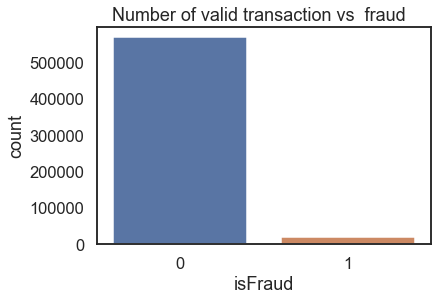

In [4]:
# Number of valid transaction vs  fraud  
sns.set(style="white", context="talk")
sns.countplot(df_train_transaction['isFraud']).set_title("Number of valid transaction vs  fraud  ")
plt.show()

In [5]:
#fraud transaction rate by weekday, hour, month-day, and year-month
START_DATE = '2017-11-30'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
df_train_transaction['Date'] = df_train_transaction['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
df_train_transaction['_ymd'] = df_train_transaction['Date'].dt.year.astype(str) + '-' + df_train_transaction['Date'].dt.month.astype(str) + '-' + df_train_transaction['Date'].dt.day.astype(str)
df_train_transaction['_year_month'] = df_train_transaction['Date'].dt.year.astype(str) + '-' + df_train_transaction['Date'].dt.month.astype(str)
df_train_transaction['_weekday'] = df_train_transaction['Date'].dt.dayofweek
df_train_transaction['_hour'] = df_train_transaction['Date'].dt.hour
df_train_transaction['_day'] = df_train_transaction['Date'].dt.day

Text(0, 0.5, 'year-month')

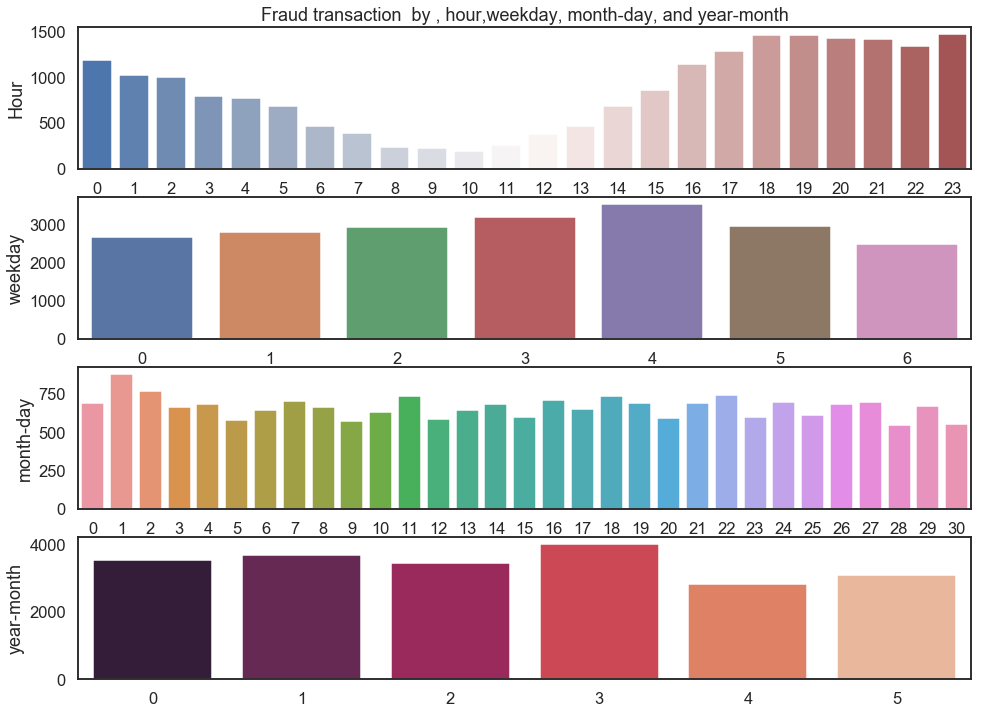

In [6]:
# Plot fraud transaction  by weekday, hour, month-day, and year-month
#V = np.array( .groupby('card4')['isFraud'].count())
X = np.array( df_train_transaction[df_train_transaction['isFraud'] == True].groupby('_hour')['isFraud'].count())
x =  np.arange(0, len(X))
Y = np.array(df_train_transaction[df_train_transaction['isFraud'] == True].groupby('_weekday')['isFraud'].count())
y = np.arange(0, len(Y))
Z =  np.array( df_train_transaction[df_train_transaction['isFraud'] == True].groupby('_day')['isFraud'].count())
z = np.arange(0, len(Z))
T = np.array(df_train_transaction[df_train_transaction['isFraud'] == True].groupby('_year_month')['isFraud'].count())
t = np.arange(0, len(T))

sns.set(style="white", context="talk")
f, (ax1, ax2, ax3,ax4) = plt.subplots(4, 1, figsize=(16, 12))
ax1.set_title('Fraud transaction  by , hour,weekday, month-day, and year-month')
sns.barplot(x=x, y=X, ax=ax1, palette="vlag")
sns.barplot(x=y, y=Y, ax=ax2, palette="deep")
sns.barplot(x=z, y=Z, ax=ax3)
sns.barplot(x=t, y=T, ax=ax4, palette="rocket")
ax1.set_ylabel("Hour")
ax2.set_ylabel("weekday")
ax3.set_ylabel("month-day")
ax4.set_ylabel("year-month")

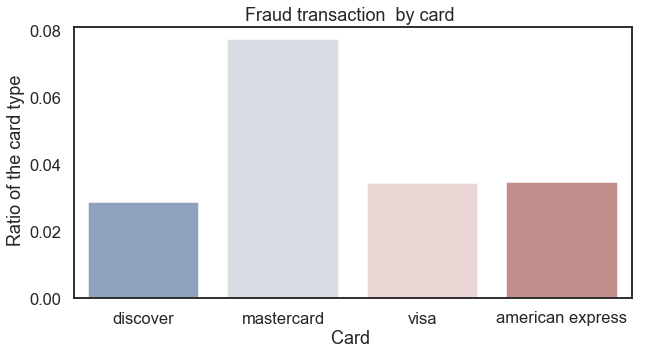

In [7]:
#Fraud transaction  by card 
V = np.array( df_train_transaction[df_train_transaction['isFraud'] == True].groupby('card4')['isFraud'].count())/ np.array( df_train_transaction.groupby('card4')['isFraud'].count())
v =  df_train_transaction["card4"].unique()[:-1]

# Plot Fraud transaction  by card 
sns.set(style="white", context="talk")
fig1,ax = plt.subplots(figsize=(10,5))
sns.barplot(x=v, y=V, palette="vlag", ax=ax).set_title('Fraud transaction  by card ')
ax.set(xlabel='Card ', ylabel=' Ratio of the card type')
plt.show()

### Prepare the data for modelling

In [8]:
# Remove the cols in df_train_transaction created for vizualization

del df_train_transaction['Date'] 
del df_train_transaction['_ymd'] 
del df_train_transaction['_year_month'] 
del df_train_transaction['_weekday']
del df_train_transaction['_hour'] 
del df_train_transaction['_day']

In [9]:
#Merge the two set of data indentity and transaction 
df_train = df_train_transaction.merge(df_train_identity, on = "TransactionID" , how = "left")

In [10]:
# Transform the categrical values in numerical values

 
def categorical_codes (name_col_str):
    ''' Function for code the categorical value to numeric '''
    df_train[name_col_str] = df_train[name_col_str].astype("category")
    df_train[name_col_str] = df_train[name_col_str].cat.codes
        

def create_col_name(base_str,start_int,end_int) :
    '''Function for deal with the column name '''
    liste = []
    for i in range (start_int,end_int+1):
        liste.append(base_str + str(i ))
    return liste

# Categorical columns name
cat_cols = (['ProductCD']+ create_col_name('card',1,6)+ [ 'addr1','addr2','P_emaildomain','R_emaildomain'] +
create_col_name('M',1,9)+ ['DeviceType',"DeviceInfo"]+ create_col_name('id_',12,38))

# Code the categorical value 
for i,j in enumerate(cat_cols) :
    categorical_codes (cat_cols[i])

In [11]:
#Dealing with the NaN replace it by the median of the column
df_train = df_train.fillna(df_train.median())

In [12]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,4,10095,-1,42,1,38,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,2987001,0,86401,29.0,4,1372,303,42,2,2,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,2987002,0,86469,59.0,4,2833,389,42,3,58,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,2987003,0,86499,50.0,4,13341,466,42,2,14,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,2987004,0,86506,50.0,1,2712,413,42,2,2,...,123,3,164,3,1,0,1,1,1,954


## Logistic Regression

In [13]:
# Choosing the features and the target
# don't use the 'TransactionID' for feature
features = [col for col in df_train.columns.tolist() if col not in  ['isFraud','TransactionID'] ]

x = df_train[features]
y =df_train['isFraud']

In [14]:
def normalize(X):
    """
    Make the distribution of the values of each variable similar 
    by subtracting the mean and by dividing by the standard deviation.
    just for the non categorical columns
   """
    for feature in X.columns:
        if feature not in cat_cols:
            X[feature] -= X[feature].mean()
            X[feature] /= X[feature].std()
    return X

#### About 5 min with:
2,6 GHz Intel Core i7  
16 Go 2400 MHz DDR4 and adeon Pro 560X 4 Go
Intel UHD Graphics 630 1536 Mo

In [15]:
# Define the model
model = LogisticRegression()

# Define the splitter for splitting the data in a train set and a test set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)

# Loop through the splits (only one)
for train_indices, test_indices in splitter.split(x, y):
    # Select the train and test data
    X_train, y_train = x.iloc[train_indices], y.iloc[train_indices]
    X_test, y_test = x.iloc[test_indices], y.iloc[test_indices]
    
# Normalize the data
X_train = normalize(X_train)
X_test = normalize(X_test)
    
# Fit and predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
    
# Show the results
print(classification_report(y_test, y_pred))

/Users/perso/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/perso/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/perso/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.97      1.00      0.99    284939
           1       0.81      0.22      0.35     10331

   micro avg       0.97      0.97      0.97    295270
   macro avg       0.89      0.61      0.67    295270
weighted avg       0.97      0.97      0.96    295270

